<a href="https://colab.research.google.com/github/A66Youssef/UAE-Real_State/blob/main/UAE_RealState.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

image.png

This dataset provides a detailed snapshot of rental property listings across major cities in the United Arab Emirates, including Abu Dhabi, Dubai, Sharjah, Ajman, Ras Al Khaimah, Umm Al Quwain, and Al Ain. Gathered from [bayut.com](https://www.bayut.com/), it includes various attributes such as property type, size, rent, and location details, making it a valuable resource for data-driven insights into the UAE rental market. Ideal for data analysts, researchers, and real estate professionals, this dataset allows for comprehensive analysis of trends, pricing, and market dynamics in the UAE's diverse rental landscape.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import  LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold
from sklearn.metrics import mean_absolute_error, r2_score
from xgboost import XGBRegressor

In [2]:
data=pd.read_csv('/content/drive/MyDrive/dubai_properties.csv')
data.head()

Address    Rent  Beds  Baths  \
0  The Gate Tower 2, The Gate Tower, Shams Gate D...  124000     3      4   
1                Water's Edge, Yas Island, Abu Dhabi  140000     3      4   
2            Al Raha Lofts, Al Raha Beach, Abu Dhabi   99000     2      3   
3  Marina Heights, Marina Square, Al Reem Island,...  220000     3      4   
4                    West Yas, Yas Island, Abu Dhabi  350000     5      7   

        Type  Area_in_sqft  Rent_per_sqft Rent_category Frequency  \
0  Apartment          1785      69.467787        Medium    Yearly   
1  Apartment          1422      98.452883        Medium    Yearly   
2  Apartment          1314      75.342466        Medium    Yearly   
3  Penthouse          3843      57.246942          High    Yearly   
4      Villa          6860      51.020408          High    Yearly   

    Furnishing   Purpose Posted_date  Age_of_listing_in_days        Location  \
0  Unfurnished  For Rent  2024-03-07                      45  Al Reem Island   
1  Unfurnished  For Rent  2024-03-08                      44      Yas Island   
2    Furnished  For Rent  2024-03-21                      31   Al Raha Beach   
3  Unfurnished  For Rent  2024-02-24                      57  Al Reem Island   
4  Unfurnished  For Rent  2024-02-16                      65      Yas Island   

        City   Latitude  Longitude  
0  Abu Dhabi  24.493598  54.407841  
1  Abu Dhabi  24.494022  54.607372  
2  Abu Dhabi  24.485931  54.600939  
3  Abu Dhabi  24.493598  54.407841  
4  Abu Dhabi  24.494022  54.607372

# **Data Preprocessing**

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73742 entries, 0 to 73741
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Address                 73742 non-null  object 
 1   Rent                    73742 non-null  int64  
 2   Beds                    73742 non-null  int64  
 3   Baths                   73742 non-null  int64  
 4   Type                    73742 non-null  object 
 5   Area_in_sqft            73742 non-null  int64  
 6   Rent_per_sqft           73742 non-null  float64
 7   Rent_category           73742 non-null  object 
 8   Frequency               73742 non-null  object 
 9   Furnishing              73742 non-null  object 
 10  Purpose                 73742 non-null  object 
 11  Posted_date             73742 non-null  object 
 12  Age_of_listing_in_days  73742 non-null  int64  
 13  Location                73742 non-null  object 
 14  City                    73742 non-null

In [4]:
data.duplicated().sum()

0

In [5]:
data.isnull().sum()

Address                     0
Rent                        0
Beds                        0
Baths                       0
Type                        0
Area_in_sqft                0
Rent_per_sqft               0
Rent_category               0
Frequency                   0
Furnishing                  0
Purpose                     0
Posted_date                 0
Age_of_listing_in_days      0
Location                    0
City                        0
Latitude                  719
Longitude                 719
dtype: int64

In [6]:
data.dropna(inplace=True)

In [7]:
data.isnull().sum()

Address                   0
Rent                      0
Beds                      0
Baths                     0
Type                      0
Area_in_sqft              0
Rent_per_sqft             0
Rent_category             0
Frequency                 0
Furnishing                0
Purpose                   0
Posted_date               0
Age_of_listing_in_days    0
Location                  0
City                      0
Latitude                  0
Longitude                 0
dtype: int64

In [8]:
data.shape

(73023, 17)

In [9]:
data['Posted_date'] = data['Posted_date'].astype('datetime64[ns]')

In [10]:
# Visualize outliers using a box plot
numerical_columns = ['Rent', 'Beds', 'Baths', 'Area_in_sqft', 'Rent_per_sqft']

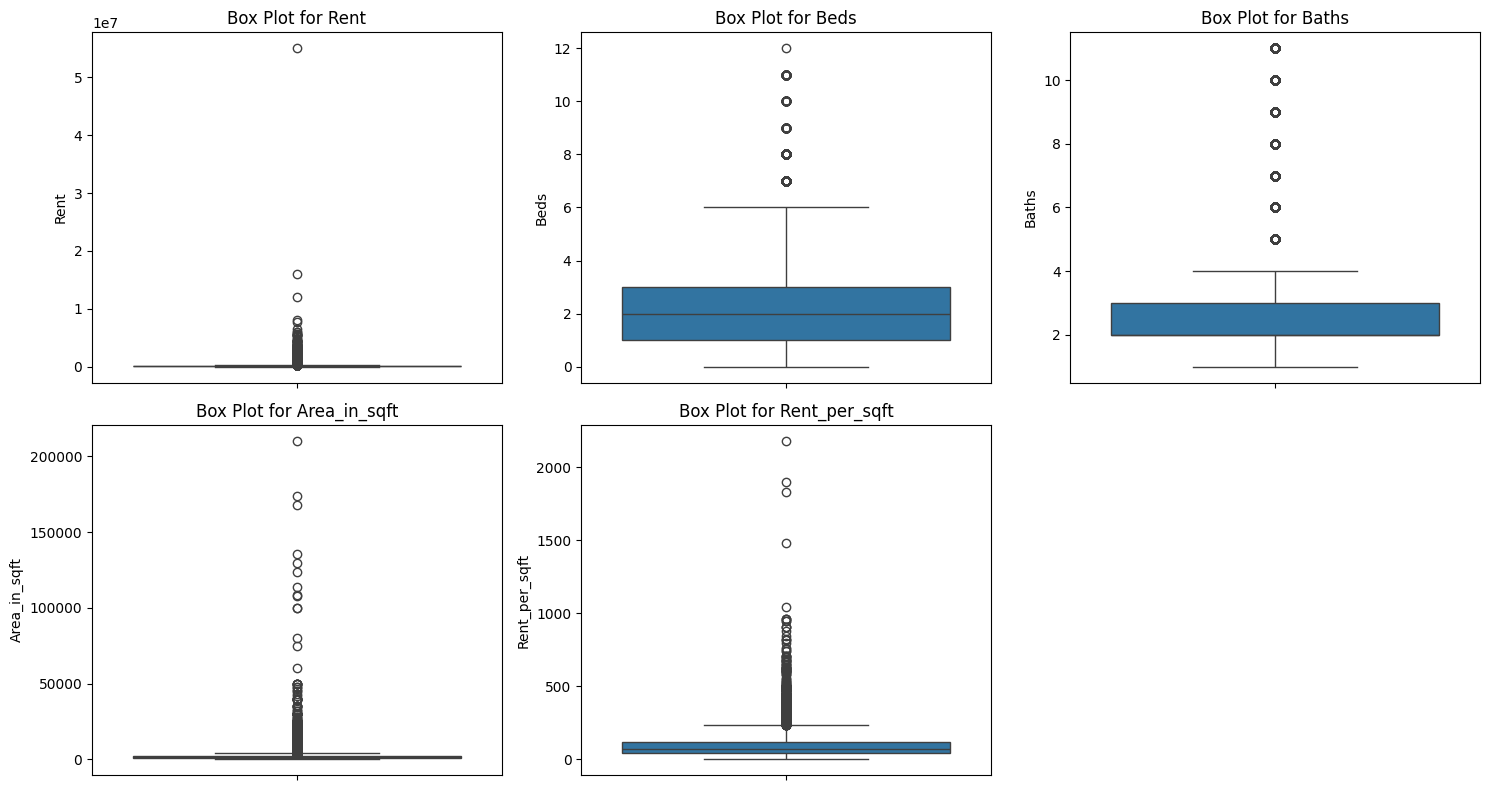

In [11]:
# Box plot for each numerical column
plt.figure(figsize=(15, 8))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(data[column])
    plt.title(f'Box Plot for {column}')
plt.tight_layout()
plt.show()

In [12]:
#  Detect and clean outliers using the IQR method
def clean_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

In [13]:
# Apply the cleaning function to all numerical columns
for col in numerical_columns:
    data = clean_outliers(data, col)

In [14]:
# Step 4: Visualize cleaned data with box plots
plt.figure(figsize=(15, 8))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(data[column])
    plt.title(f'Box Plot for Cleaned {column}')
plt.tight_layout()
plt.show()

# EDA

In [15]:
city_area_rent = data.groupby('City').agg({'Area_in_sqft':'mean','Rent':'mean'}).reset_index()

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,9),dpi=100)
fig.patch.set_facecolor('#ffe6e6')
yaxes = ['Area_in_sqft','Rent']
palettes = ['spring','cool']
limit=[[0,1550],[0,110000]]
ylabel = ['Area_in_sqft','Rent']
text = [100,2000]
count = 0
for i in [ax1,ax2]:
    c_no = 0
    i.set_facecolor('#ffe6e6')
    sns.barplot(data=city_area_rent,x='City',y=yaxes[count],palette=palettes[count],ax=i)
    i.grid(axis='y',linewidth=1,alpha=0.5,color='#000000',linestyle=':',dashes=(1,5))
    i.set(ylim=limit[count])
    for j in ['top','right','left','bottom']:
        i.spines[j].set_visible(False)
    i.set_title('City vs {}'.format(yaxes[count]),size=16,color='black',fontweight='bold')
    i.set_xlabel('\nCity\n',size=14,color='black')
    i.set_ylabel('\n\nAverage {}'.format(ylabel[count]),size=14,color='black')
    i.set_xticks([])
    for j in i.patches:
        i.text(j.get_x()+0.2,text[count],city_area_rent['City'][c_no],rotation='vertical',weight='bold',color='black',fontsize=14)
        c_no = c_no+1
    count = count + 1

<ipython-input-15-3604cf00243a>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=city_area_rent,x='City',y=yaxes[count],palette=palettes[count],ax=i)
<ipython-input-15-3604cf00243a>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=city_area_rent,x='City',y=yaxes[count],palette=palettes[count],ax=i)


In [16]:
room_type_rent = data.groupby('Type')['Rent'].mean().sort_values(ascending=True).reset_index()
fig,ax = plt.subplots(figsize = (12,8),dpi = 80)
fig.patch.set_facecolor('#ffe6e6')
ax.set_facecolor('#ffe6e6')
sns.barplot(data=room_type_rent,x='Type',y='Rent',palette='cool')
ax.grid(axis='y',linewidth=1,alpha=0.5,color='#000000',linestyle=':',dashes=(1,5))
#plt.title('\nRoom Type vs Average Rent\n',fontsize=18,c='#000000',fontweight='bold',fontfamily='seriff')
plt.xlabel('\nRoom Type\n',c='#000000',fontsize=15,fontweight='bold',fontfamily='seriff')
plt.ylabel('\nAverage Rent\n',c='#000000',fontsize=15,fontweight='bold',fontfamily='seriff')
ax.set(ylim=(0,150000))
plt.xticks([],rotation=10,fontsize=12)
plt.yticks(fontsize=12)

for i in ['left','top','right','bottom']:
    ax.spines[i].set_visible(False)

count = 0
for i in ax.patches:
    if i.get_height()<40000:
        ax.text(i.get_x()+0.3,2000,room_type_rent['Type'][count],weight='bold',fontsize=11,color='black',rotation='vertical')
        ax.text(i.get_x()+0.07,i.get_height()+4000,round(i.get_height(),2),weight='bold',fontsize=11,color='black')
    elif 40000<i.get_height()<55000:
        ax.text(i.get_x()+0.3,2000,room_type_rent['Type'][count],weight='bold',fontsize=12,color='black',rotation='vertical')
        ax.text(i.get_x()+0.07,i.get_height()+4000,round(i.get_height(),2),weight='bold',fontsize=11,color='black')
    else:
        ax.text(i.get_x()+0.3,8000,room_type_rent['Type'][count],weight='bold',fontsize=15,color='black',rotation='vertical')
        ax.text(i.get_x(),i.get_height()+4000,round(i.get_height(),2),weight='bold',fontsize=11,color='black')

    count = count + 1

<ipython-input-16-be19c012b1d8>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=room_type_rent,x='Type',y='Rent',palette='cool')


In [17]:
# Import the plotly.express module and alias it as px
import plotly.express as px

temp = data.groupby(['Furnishing','Rent_category'])['Rent_category'].count().to_frame().rename(columns={'Rent_category':'count'}).reset_index()
fig = px.sunburst(temp, path=['Furnishing', 'Rent_category'], values='count',color='Rent_category',color_discrete_map={'(?)':'#ff00ff','Low':'#aa55ff','Medium':'#55aaff','High':'#00ffff'})
fig.update_layout(title={
        'text':''},
        font=dict(size=15, color='black'),
        margin=dict(l=0, r=80, t=55, b=10),
        plot_bgcolor='#ffe6e6', paper_bgcolor='#ffe6e6'
    )
fig.update_traces(textinfo="label+value")

In [18]:
locations_rent = data.groupby('Location')['Rent_per_sqft'].mean().sort_values(ascending=False).head(10).reset_index()
fig,ax = plt.subplots(figsize = (12,7),dpi = 80)
fig.patch.set_facecolor('#ffe6e6')
ax.set_facecolor('#ffe6e6')
sns.barplot(data=locations_rent,x='Location',y='Rent_per_sqft',palette='cool_r')
ax.grid(axis='y',linewidth=1,alpha=0.5,color='#000000',linestyle=':',dashes=(1,5))
plt.title('\nTop 10 Locations with Highest\nAverage Rent_per_sqft\n',fontsize=18,c='#000000',fontweight='bold',fontfamily='seriff')
plt.xlabel('\nLocation',c='#000000',fontsize=15,fontweight='bold',fontfamily='seriff')
plt.ylabel('\nRents per Sqft\n',c='#000000',fontsize=15,fontweight='bold',fontfamily='seriff')
plt.xticks([],rotation=90,fontsize=12)
plt.yticks(fontsize=12)

for i in ['left','top','right','bottom']:
    ax.spines[i].set_visible(False)

count = 0
for i in ax.patches:
    ax.text(i.get_x()+0.35,15,locations_rent['Location'][count],weight='bold',fontsize=14,color='black',rotation='vertical')
    ax.text(i.get_x()+0.02,i.get_height()+4,round(i.get_height(),2),weight='bold',fontsize=10,color='black')
    count = count + 1

<ipython-input-18-3552f59b5cbf>:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




# Label Encoding

In [19]:
# Initialize LabelEncoder
le = LabelEncoder()

# Apply One Hot Encoder to the specified columns
# Removed 'Purpose' from the list as it does not seem to exist
for column in ['Type', 'Furnishing', 'Location', 'City','Purpose','Frequency','Rent_category']:
    # Reshape the column data to a 2D array
    reshaped_data = data[column].values.reshape(-1, 1)

    # Use the reshaped data for encoding
    encoded_data = le.fit_transform(reshaped_data)

    # Assign the encoded data to the DataFrame column (no need for toarray())
    data[column] = encoded_data

# Display the encoded DataFrame
data.head()

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessin

Address    Rent  Beds  Baths  \
0  The Gate Tower 2, The Gate Tower, Shams Gate D...  124000     3      4   
1                Water's Edge, Yas Island, Abu Dhabi  140000     3      4   
2            Al Raha Lofts, Al Raha Beach, Abu Dhabi   99000     2      3   
5  Reflection, Shams Abu Dhabi, Al Reem Island, A...   75000     1      1   
6                Water's Edge, Yas Island, Abu Dhabi   65000     1      1   

   Type  Area_in_sqft  Rent_per_sqft  Rent_category  Frequency  Furnishing  \
0     0          1785      69.467787              2          0           1   
1     0          1422      98.452883              2          0           1   
2     0          1314      75.342466              2          0           0   
5     0           706     106.232295              2          0           0   
6     0           698      93.123209              1          0           1   

   Purpose Posted_date  Age_of_listing_in_days  Location  City   Latitude  \
0        0  2024-03-07                      45       109     0  24.493598   
1        0  2024-03-08                      44       300     0  24.494022   
2        0  2024-03-21                      31        98     0  24.485931   
5        0  2023-12-12                     131       109     0  24.493598   
6        0  2024-03-11                      41       300     0  24.494022   

   Longitude  
0  54.407841  
1  54.607372  
2  54.600939  
5  54.407841  
6  54.607372

In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56776 entries, 0 to 73738
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Address                 56776 non-null  object        
 1   Rent                    56776 non-null  int64         
 2   Beds                    56776 non-null  int64         
 3   Baths                   56776 non-null  int64         
 4   Type                    56776 non-null  int64         
 5   Area_in_sqft            56776 non-null  int64         
 6   Rent_per_sqft           56776 non-null  float64       
 7   Rent_category           56776 non-null  int64         
 8   Frequency               56776 non-null  int64         
 9   Furnishing              56776 non-null  int64         
 10  Purpose                 56776 non-null  int64         
 11  Posted_date             56776 non-null  datetime64[ns]
 12  Age_of_listing_in_days  56776 non-null  int64      

# Correlation

In [21]:
numeric_columns = data.select_dtypes(include=['float64', 'int64'])
# Calculate the correlation matrix
corr_matrix = numeric_columns.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [22]:
data=data.drop('Purpose', axis=1, errors='ignore')
data=data.drop('Frequency', axis=1, errors='ignore')
print(data.columns)

Index(['Address', 'Rent', 'Beds', 'Baths', 'Type', 'Area_in_sqft',
       'Rent_per_sqft', 'Rent_category', 'Furnishing', 'Posted_date',
       'Age_of_listing_in_days', 'Location', 'City', 'Latitude', 'Longitude'],
      dtype='object')


In [23]:
numeric_columns = data.select_dtypes(include=['float64', 'int64'])
# Calculate the correlation matrix
corr_matrix = numeric_columns.corr()
# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

# Feature Selection

In [24]:
# Feature selection (drop columns that may not help in prediction)
X = data.drop(columns=['Rent', 'Address', 'Posted_date'])  # Features
y = data['Rent']  # Target

# XGBOST

In [25]:
# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
# Initialize the XGBoost Regressor
xgbr = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

In [27]:
# Train the model
xgbr.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [28]:
# Make predictions
y_pred = xgbr.predict(X_test)

# Evaluation

In [29]:
# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'R-squared: {r2}')

Mean Absolute Error: 5687.703452384065
R-squared: 0.9877615988753828


In [30]:
plt.scatter(y_test, y_test, color='blue', label='Actual Values (y_test)')
plt.scatter(y_test, y_pred, color='pink', label='Predicted Values (y_pred)')

# Add labels, legend, and a title
plt.xlabel("Actual Values (y_test)")
plt.ylabel("Predicted Values (y_pred)")
plt.title("Comparison of Actual vs. Predicted Values")
plt.legend()

# Show the plot
plt.show()